# Mapper applied to ensembles
Use entropy-based dissimilarity and seats or EG as filtration.

In [1]:
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election, metrics)
from gerrychain.proposals import recom
from functools import partial
import pandas
import networkx
import numpy as np
import geopandas as gpd
import shapely
from scipy.stats.stats import pearsonr
import mapper
from scipy.spatial.distance import pdist, squareform

Mapper warning: Could not load the module “fastcluster”.
The module “scipy.cluster.hierarchy“ is used instead, but it will be slower.
The 'cmappertools' module could not be imported.
The 'cmappertools' module could not be imported.
Intrinsic metric is not available.
The 'cmappertools' module could not be imported.


In [2]:
import graphviz

In [3]:
graph = Graph.from_file("../mggg-states/IL-shapefiles/Chicago/Chicago_Precincts/Chicago_Precincts.shp")

city = gpd.read_file("../mggg-states/IL-shapefiles/Chicago/Chicago_Precincts/Chicago_Precincts.shp")

/Users/michellefeng/anaconda/envs/vrdi2019/lib/python3.7/site-packages/gerrychain/graph/adjacency.py:68: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(410, 1381), (26, 410), (410, 717), (105, 169)}
  overlaps


In [3]:
city.head

<bound method NDFrame.head of      full_text  precinct    shape_area      shape_len  ward       TOTPOP  \
0        41027      27.0  3.090762e+08  139749.430317  41.0  2197.199822   
1        05025      25.0  2.569525e+07   35894.522176   5.0  1179.000035   
2        48041      41.0  1.248113e+06    4917.914119  48.0  2077.999953   
3        03024      24.0  5.716768e+06   12629.240176   3.0  1677.000001   
4        02045      45.0  4.762711e+05    2986.071131   2.0  1448.999997   
5        20029      29.0  4.269571e+06   10168.308279  20.0  1520.999990   
6        10013      13.0  2.027402e+08   70199.480252  10.0  1655.999998   
7        29021      21.0  1.940289e+06    5575.044341  29.0  2116.999958   
8        04011      11.0  3.127426e+06   11089.037796   4.0  2040.999957   
9        10001       1.0  5.626781e+06   10344.127078  10.0  1240.936850   
10       48031      31.0  1.093626e+06    4308.690572  48.0  2607.000133   
11       20013      13.0  4.722735e+06    8882.764063  20.

In [111]:
demos = ["TOTPOP", "H_WHITE", "H_BLACK", "H_ASIAN", "H_OTHER", "NH_WHITE", "NH_BLACK", "NH_ASIAN", "LHGTFT_19", "PRECK_19"]
bad_columns = [var for var in demos if city[var].dtype != "int"]

for column in bad_columns:
    city[column] = city[column].astype(int)
    
city = city[city["TOTPOP"]>0]

In [112]:
city["wper"] = city["NH_WHITE"]/city["TOTPOP"]
city["bper"] = city["NH_BLACK"]/city["TOTPOP"]
city["hwper"] = city["H_WHITE"]/city["TOTPOP"]
city["hbper"] = city["H_BLACK"]/city["TOTPOP"]
city["haper"] = city["H_ASIAN"]/city["TOTPOP"]
city["hoper"] = city["H_OTHER"]/city["TOTPOP"]
city["aper"] = city["NH_ASIAN"]/city["TOTPOP"]
city["eman_per"] = city["LHGTFT_19"]/(city["LHGTFT_19"]+city["PRECK_19"])

In [113]:
num_precincts = len(city)
demo_attrs = ["wper", "bper", "aper", "hwper", "hbper", "haper", "hoper"]
demo_pt_cloud = np.zeros((num_precincts,len(demo_attrs)))

for i in range(len(demo_attrs)):
    demo_pt_cloud[:,i] = city[demo_attrs[i]].values

In [117]:
n_data = num_precincts #number of data point
distance_matrix = squareform(pdist(demo_pt_cloud,"minkowski", p=1)) #pairwise distances as a matrix
filter_values = city["eman_per"].values #filtration values of data
n_interval = 5 #number of intervals in cover
cluster_parameter = 0.05 #tunable

In [48]:
straightened_distance_matrix = []
for i in range(0, n_data):
    for j in range(i+1, n_data):
        straightened_distance_matrix.append(max(0,distance_matrix[i][j]))

Upper triangular distance matrix: 


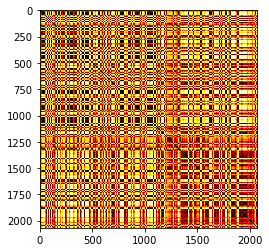

In [68]:
print("Upper triangular distance matrix: ")
plt.imshow(distance_matrix, cmap="hot")
plt.show()

In [121]:
covers = mapper.cover.cube_cover_primitive(intervals=n_interval, overlap=.49)
#covers = mapper.cover.balanced_cover_1d(intervals=n_interval)

Number of CPU cores present: 4
Start Mapper thread.Start Mapper thread.

Start Mapper thread.
Start Mapper thread.
Mapper: Filter range in dimension 0: [0.12, 1.00]
Mapper: Cover: Hypercube cover. Intervals: (5,). Overlap: (0.49,)
Mapper: Clustering: Single linkage clustering
Mapper: Cutoff: First gap of relative width 0.05
Level: (0,)
Level: (1,)
Level: (2,)
Level: (3,)
Level: (4,)
Filter level (2,) has 720 points.
Filter level (0,) has 157 points.
Filter level (1,) has 783 points.
Filter level (3,) has 411 points.
Filter level (4,) has 11 points.
There are 23 nodes.
Generate the simplicial complex.
Collect simplices of dimension 1:
There are 3 simplices of dimension 1.
Collect simplices of dimension 2:
There are 0 simplices of dimension 2.
Dimension: 1


((19.555721145184002,
  -247.7058011723307,
  323.7558278480463,
  -10.864289525102215,
  0.28766738322983026),
 array([ 0,  1,  2,  3,  4,  5,  6, 22,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21]),
 array([[ 318.32368309, -187.95220878],
        [ 195.55721145, -162.96434288],
        [ 137.43326249, -186.32256536],
        [  84.7414583 ,  -70.61788191],
        [ 255.31080384, -157.53219811],
        [ 260.7429486 , -217.2857905 ],
        [  36.01511978, -131.07765312],
        [ 108.18188723, -127.68002764],
        [ 200.98935621, -222.71793526],
        [ 160.79148497,  -45.63001601],
        [ 220.54507736,  -40.19787124],
        [  82.56860039, -245.53294327],
        [ 142.86540726, -246.07615774],
        [ 278.12581184,  -10.86428953],
        [  53.23501867, -187.95220878],
        [  24.98786591,  -76.05002668],
        [  19.55572115,  -16.29643429],
        [  79.30931353,  -10.86428953],
        [ 307.45939356,  -68.44502401],
        [ 312.8915

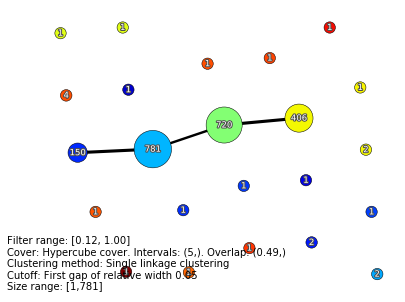

In [122]:
maps = mapper.mapper(np.array(distance_matrix), filter_values, covers, cutoff=mapper.cutoff.first_gap(cluster_parameter))
mapper.draw_mapper_output.draw_2D(maps, node_color_scheme=None)

City-wide mean attributes:  [0.32922247 0.36970044 0.04839611 0.10940854 0.00527139 0.00067414
 0.10423587]
Level:  (0,)   Number of points:  1   Mean filter:  0.2857142857142857
Mean attribute vector:  [0.24 0.01 0.69 0.03 0.   0.   0.01]
Precincts in node (shown in yellow):


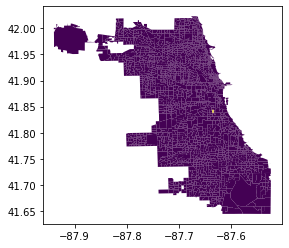

Level:  (0,)   Number of points:  1   Mean filter:  0.2777777777777778
Mean attribute vector:  [0.05 0.58 0.32 0.01 0.   0.   0.  ]
Precincts in node (shown in yellow):


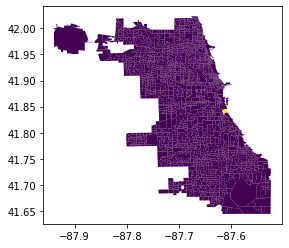

Level:  (0,)   Number of points:  1   Mean filter:  0.26666666666666666
Mean attribute vector:  [0.68 0.   0.   0.2  0.   0.   0.11]
Precincts in node (shown in yellow):


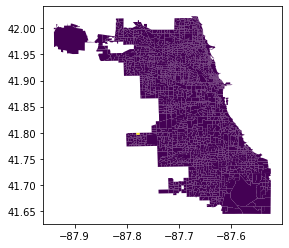

Level:  (0,)   Number of points:  1   Mean filter:  0.17647058823529413
Mean attribute vector:  [0.92 0.   0.02 0.03 0.   0.   0.  ]
Precincts in node (shown in yellow):


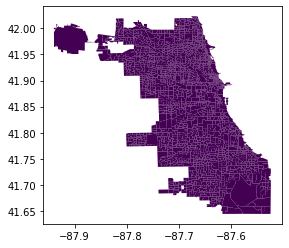

Level:  (0,)   Number of points:  1   Mean filter:  0.2
Mean attribute vector:  [0.65 0.19 0.02 0.06 0.01 0.   0.04]
Precincts in node (shown in yellow):


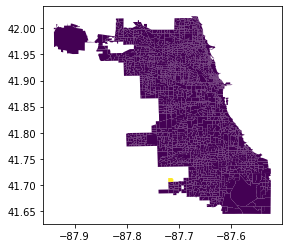

Level:  (0,)   Number of points:  2   Mean filter:  0.25
Mean attribute vector:  [0.32 0.22 0.38 0.04 0.   0.   0.02]
Precincts in node (shown in yellow):


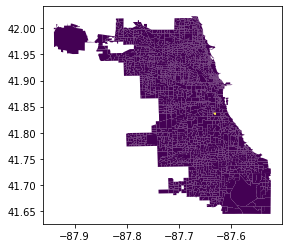

Level:  (0,)   Number of points:  150   Mean filter:  0.26245567375886525
Mean attribute vector:  [0.03 0.73 0.01 0.09 0.01 0.   0.11]
Precincts in node (shown in yellow):


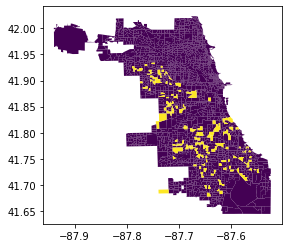

Level:  (4,)   Number of points:  1   Mean filter:  0.8717948717948718
Mean attribute vector:  [0.5  0.01 0.2  0.14 0.   0.   0.1 ]
Precincts in node (shown in yellow):


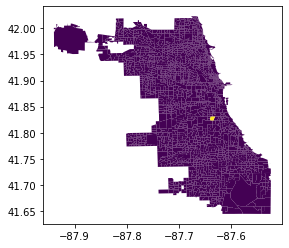

Level:  (4,)   Number of points:  1   Mean filter:  0.8461538461538461
Mean attribute vector:  [0.27 0.02 0.   0.3  0.01 0.   0.36]
Precincts in node (shown in yellow):


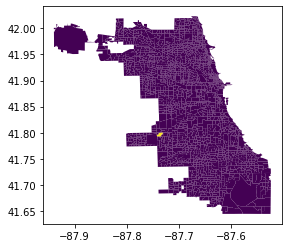

Level:  (4,)   Number of points:  1   Mean filter:  0.8571428571428571
Mean attribute vector:  [0.77 0.   0.01 0.12 0.   0.   0.08]
Precincts in node (shown in yellow):


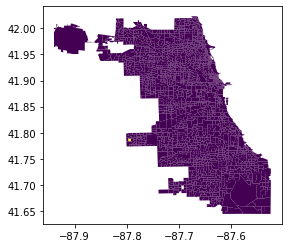

Level:  (4,)   Number of points:  1   Mean filter:  1.0
Mean attribute vector:  [0.04 0.01 0.   0.45 0.   0.   0.47]
Precincts in node (shown in yellow):


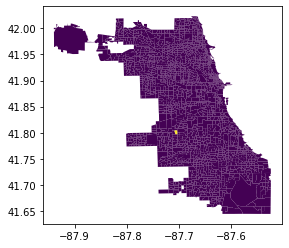

Level:  (4,)   Number of points:  1   Mean filter:  0.8260869565217391
Mean attribute vector:  [0.14 0.03 0.   0.34 0.01 0.   0.42]
Precincts in node (shown in yellow):


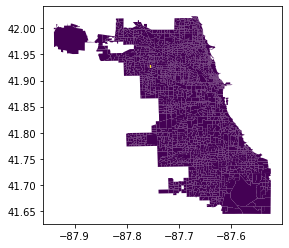

Level:  (4,)   Number of points:  1   Mean filter:  0.9090909090909091
Mean attribute vector:  [0.64 0.03 0.01 0.15 0.01 0.   0.12]
Precincts in node (shown in yellow):


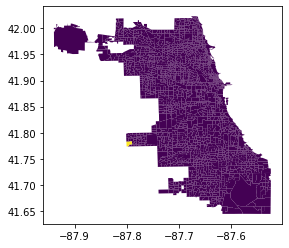

Level:  (4,)   Number of points:  1   Mean filter:  0.8390804597701149
Mean attribute vector:  [0.81 0.01 0.04 0.06 0.   0.   0.04]
Precincts in node (shown in yellow):


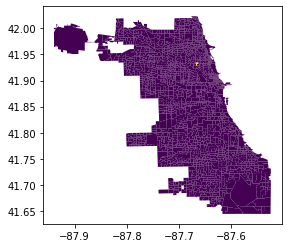

Level:  (4,)   Number of points:  4   Mean filter:  0.8452380952380952
Mean attribute vector:  [0.93 0.01 0.   0.03 0.   0.   0.01]
Precincts in node (shown in yellow):


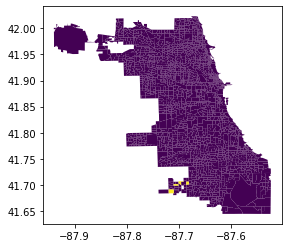

Level:  (3,)   Number of points:  1   Mean filter:  0.6666666666666666
Mean attribute vector:  [0.3  0.   0.54 0.07 0.   0.01 0.06]
Precincts in node (shown in yellow):


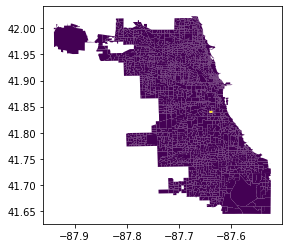

Level:  (3,)   Number of points:  1   Mean filter:  0.6666666666666666
Mean attribute vector:  [0.02 0.56 0.   0.18 0.01 0.   0.16]
Precincts in node (shown in yellow):


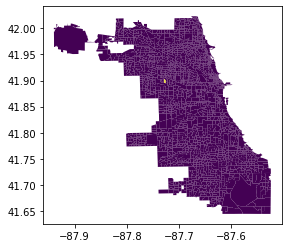

Level:  (3,)   Number of points:  1   Mean filter:  0.6923076923076923
Mean attribute vector:  [0.04 0.86 0.   0.   0.03 0.   0.02]
Precincts in node (shown in yellow):


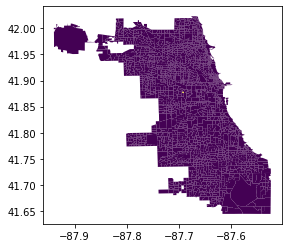

Level:  (3,)   Number of points:  2   Mean filter:  0.6888477088948787
Mean attribute vector:  [0.21 0.01 0.37 0.19 0.   0.01 0.19]
Precincts in node (shown in yellow):


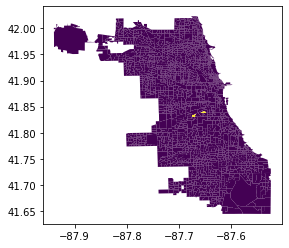

Level:  (3,)   Number of points:  406   Mean filter:  0.6875
Mean attribute vector:  [0.69 0.04 0.07 0.1  0.   0.   0.07]
Precincts in node (shown in yellow):


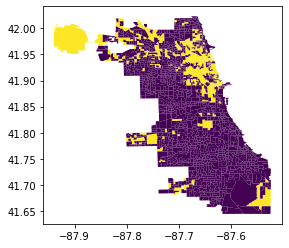

Level:  (2,)   Number of points:  720   Mean filter:  0.5679012345679012
Mean attribute vector:  [0.44 0.15 0.08 0.15 0.01 0.   0.14]
Precincts in node (shown in yellow):


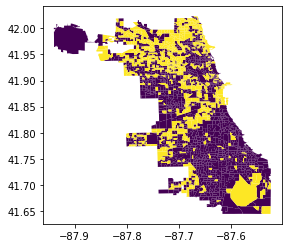

Level:  (1,)   Number of points:  2   Mean filter:  0.37364130434782605
Mean attribute vector:  [0.05 0.04 0.87 0.01 0.   0.   0.01]
Precincts in node (shown in yellow):


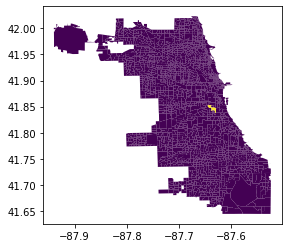

Level:  (1,)   Number of points:  781   Mean filter:  0.38461538461538464
Mean attribute vector:  [0.09 0.69 0.02 0.08 0.01 0.   0.09]
Precincts in node (shown in yellow):


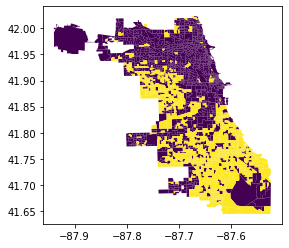

In [123]:
mean = np.zeros(len(demo_attrs))
for i in range(len(demo_attrs)):
        mean[i] = np.mean(demo_pt_cloud[:,i])
print("City-wide mean attributes: ", mean)
for node in maps.nodes:
    mean = np.zeros(len(demo_attrs))
    for i in range(len(demo_attrs)):
        mean[i] = np.mean([demo_pt_cloud[z,i] for z in node.points])
    ass = {x:0 for x in graph.nodes}
    for i in node.points:
        ass[i] = 1
    geo = GeographicPartition(graph, ass)
    print("Level: ", node.level, "  Number of points: ", len(node.points), "  Mean filter: ", node.attribute)
    print("Mean attribute vector: ", np.round_(mean, decimals=2))
    print("Precincts in node (shown in yellow):")
    geo.plot(city)
    plt.show()